In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)




# Data set cleaned for Covid-19 modelling

the file COVED_small_flat_table has to be generated via the NOTEBOOK DATA PREPARATION

Goal of the exercise a dynamic dashboard of the last cell in the notebook, where one can select the fit for different countries

Fit of SIR model for Germany cases


In [2]:
# try to parse the dates right at the beginning 
# it works out of the box if the date was stored ISO YYYY-MM-DD format


df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True)

,date,Italy,US,Spain,Germany,"Korea, South"
0,2020-01-22,0,1,0,0,1
1,2020-01-23,0,1,0,0,1
2,2020-01-24,0,2,0,0,2
3,2020-01-25,0,2,0,0,2
4,2020-01-26,0,5,0,0,3
...,...,...,...,...,...,...
867,2022-06-07,17543136,85003945,12436538,26583016,18188200
868,2022-06-08,17566061,85214036,12436538,26660652,18200346
869,2022-06-09,17589595,85329656,12436538,26738530,18209650
870,2022-06-10,17611607,85468816,12478994,26803867,18218078


In [3]:
## Nice mathematical explanation of the differential SIR 
# https://www.youtube.com/watch?v=NKMHhm2Zbkw

In [4]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate

## beta/gamma is the basic reproduction number, <1 means no spread virus


# condition I0+S0+R0=N0
I0=df_analyse.Germany[35]
S0=N0-I0
R0=0

In [5]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])


# Simulative approach to calculate SIR curves

In [6]:

SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)


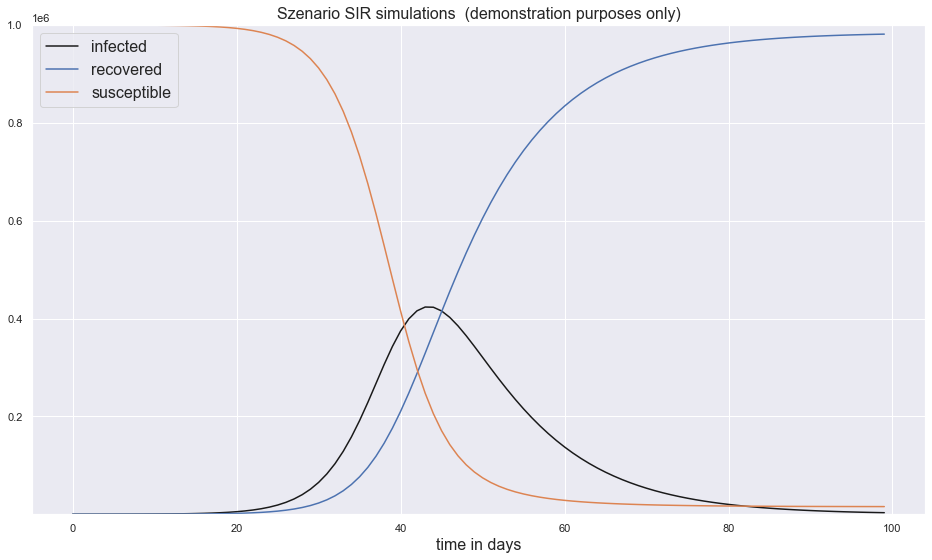

In [7]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Fitting data to a model

## step one: always start on simulative / constructive data

Goal is to fit a data model (SIR) model to obtain the parameters
beta and gamma

step one: always start on simulative / constructive data
step two: cross check if the innerlogic of your parameter fitting is correct

In [8]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [9]:
# the resulting curve has to be fitted
# free parameters are here beta and gamma

def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [10]:
## fit the data set ydata, here the simulative data set of the infected curve

ydata = propagation_rates.infected
t=np.arange(len(ydata))

In [11]:
#ydata

In [12]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])



<ipython-input-8-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-8-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-8-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
D:\Anaconda\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [0.00087012 0.00074077]  start infect: 27.299823600000003
Optimal parameters: beta = 0.37337789054916876  and gamma =  0.09619940540430044


In [13]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

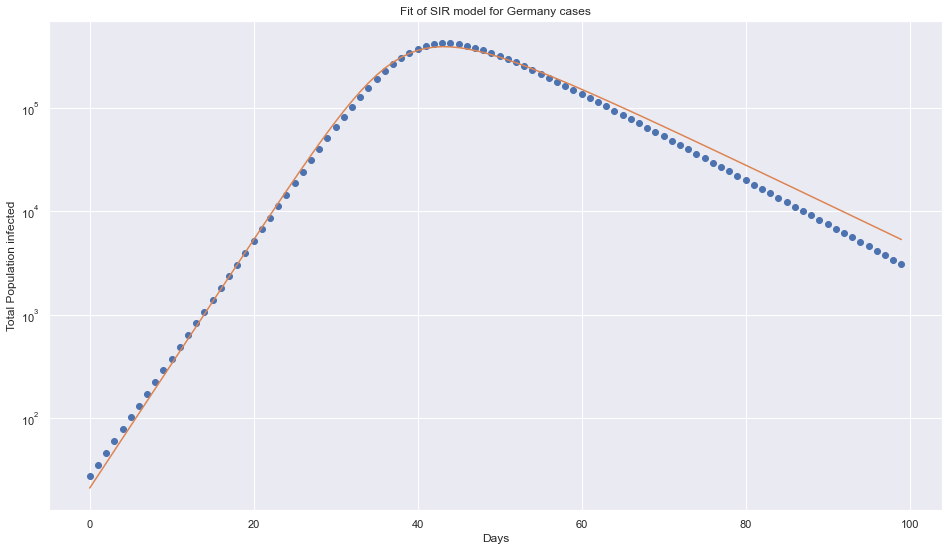

Optimal parameters: beta = 0.37337789054916876  and gamma =  0.09619940540430044
Basic Reproduction Number R0  3.8812910431198726
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [14]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
#plt.semilogy(fitted)

plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Total Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

# Fitting the parameters of SIR model
the SIR model is assuming a very simplistic curve
however we can find situations (time windows) where the model might apply

In [15]:
## slice out some true data of a country

ydata = np.array(df_analyse.Germany[40::])
t=np.arange(len(ydata))

In [16]:
# ensure re-initialization 
# attenion when slicing gout only a time window 
# (one Corana wave) the overall N0 is not the full popoulation size 
N0=10000000

I0=ydata[0]
S0=N0-I0
R0=0
print('start infected:',I0)
print('cumulative sum of invected after period',ydata[-1])
print('Number of days',len(ydata))
print('N0',N0)

start infected: 150
cumulative sum of invected after period 26803867
Number of days 832
N0 10000000


In [17]:

## get the model parameters / fit the model
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

# get the final fitted curve / predict the outcome 
germany_fitted=fit_odeint(t, *popt)

D:\Anaconda\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-8-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-8-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-8-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
D:\Anaconda\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [1.38564407e-04 8.83788147e-05]  start infect: 150
Optimal parameters: beta = 0.011676770607530907  and gamma =  -0.0054608924924184205


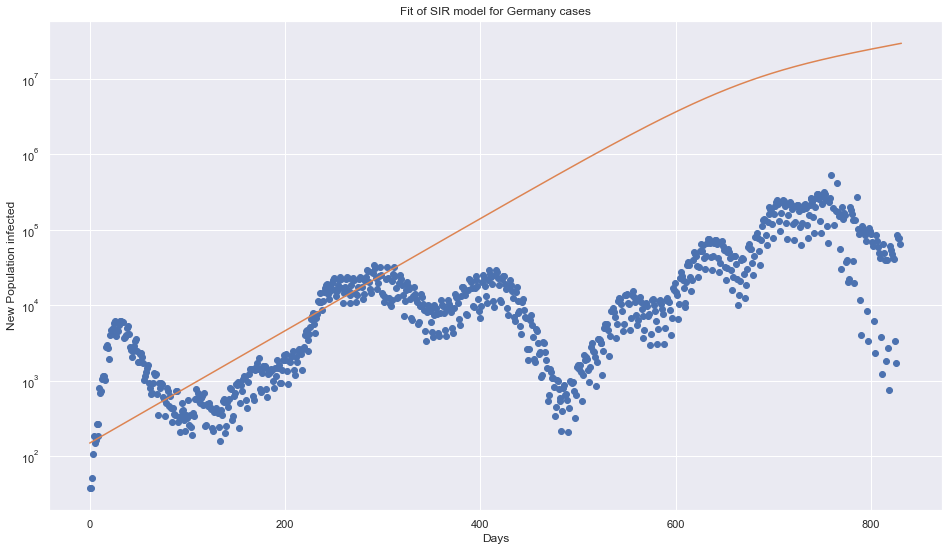

Optimal parameters: beta = 0.011676770607530907  and gamma =  -0.0054608924924184205
Basic Reproduction Number R0  -2.138253156190539
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [18]:
# option 1: ydata is cummulative, thus we need cumulative fitted line
#plt.semilogy(t, ydata, 'o') 
#plt.semilogy(t, np.cumsum(fitted))

# option2: ydata is cummulative, however we would like to have the day to day difference
plt.semilogy(t,np.ediff1d(ydata, to_begin=ydata[1]-ydata[0]), 'o')
plt.semilogy(t, germany_fitted)

plt.title("Fit of SIR model for Germany cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

# Fitting Model to Italian Cases

In [19]:
## slice out some true data of a country

ydata_i = np.array(df_analyse.Italy[40:])
t_i=np.arange(len(ydata_i))

In [20]:
# ensure re-initialization 
# attenion when slicing gout only a time window 
# (one Corana wave) the overall N0 is not the full popoulation size 
N0_i=10000000

I0_i=ydata_i[0]
S0_i=N0_i-I0_i
R0_i=0
print('start infected:',I0_i)
print('cumulative sum of invected after period',ydata_i[-1])
print('Number of days',len(ydata_i))
print('N0',N0_i)

start infected: 2036
cumulative sum of invected after period 17634065
Number of days 832
N0 10000000


In [21]:
## get the model parameters / fit the model
popt_i, pcov_i = optimize.curve_fit(fit_odeint, t_i, ydata_i)
perr_i = np.sqrt(np.diag(pcov_i))
    
print('standard deviation errors : ',str(perr_i), ' start infect:',ydata_i[0])
print("Optimal parameters: beta =", popt_i[0], " and gamma = ", popt_i[1])

# get the final fitted curve / predict the outcome 
italy_fitted=fit_odeint(t_i, *popt_i)

D:\Anaconda\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-8-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-8-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-8-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
D:\Anaconda\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [1.62707520e-04 8.99506105e-05]  start infect: 2036
Optimal parameters: beta = 0.015105254561500742  and gamma =  -0.0027199233224339766


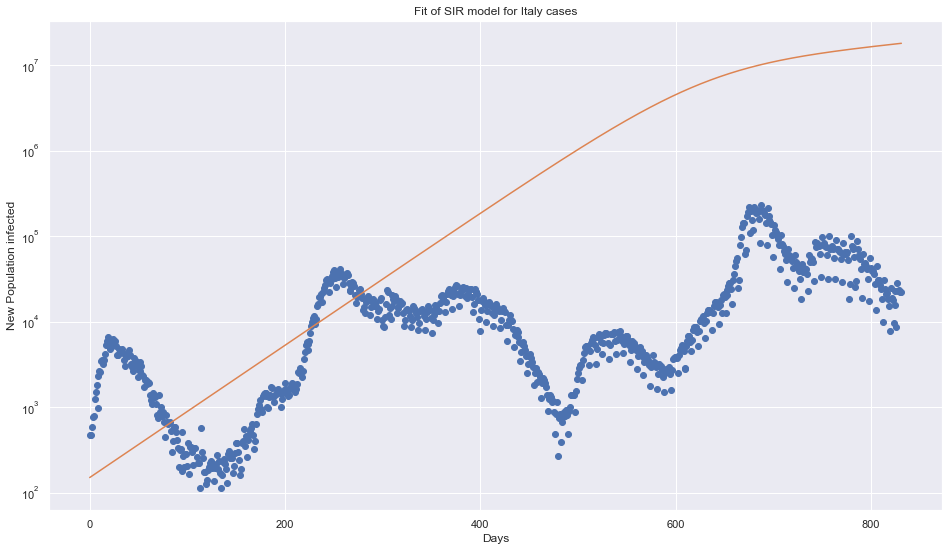

Optimal parameters: beta = 0.015105254561500742  and gamma =  -0.0027199233224339766
Basic Reproduction Number R0  -5.553558968707805
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [22]:
plt.semilogy(t,np.ediff1d(ydata_i, to_begin=ydata_i[1]-ydata_i[0]), 'o')
plt.semilogy(t_i, italy_fitted)

plt.title("Fit of SIR model for Italy cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt_i[0], " and gamma = ", popt_i[1])
print("Basic Reproduction Number R0 " , popt_i[0]/ popt_i[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

# Fitting Model to US Cases

In [23]:
## slice out some true data of a country

ydata_u = np.array(df_analyse.US[40:])
t_u=np.arange(len(ydata_u))

In [24]:
# ensure re-initialization 
# attenion when slicing gout only a time window 
# (one Corana wave) the overall N0 is not the full popoulation size 
N0_u=10000000

I0_u=ydata_u[0]
S0_u=N0_u-I0_u
R0_u=0
print('start infected:',I0_u)
print('cumulative sum of invected after period',ydata_u[-1])
print('Number of days',len(ydata_u))
print('N0',N0_u)

start infected: 55
cumulative sum of invected after period 85500976
Number of days 832
N0 10000000


In [25]:
## get the model parameters / fit the model
popt_u, pcov_u = optimize.curve_fit(fit_odeint, t_u, ydata_u)
perr_u = np.sqrt(np.diag(pcov_u))
    
print('standard deviation errors : ',str(perr_u), ' start infect:',ydata_u[0])
print("Optimal parameters: beta =", popt_u[0], " and gamma = ", popt_u[1])

# get the final fitted curve / predict the outcome 
us_fitted=fit_odeint(t_u, *popt_u)

D:\Anaconda\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-8-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-8-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-8-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
D:\Anaconda\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [1.98803378e-04 9.29622955e-06]  start infect: 55
Optimal parameters: beta = 0.08582515669010742  and gamma =  -0.003227808452489312


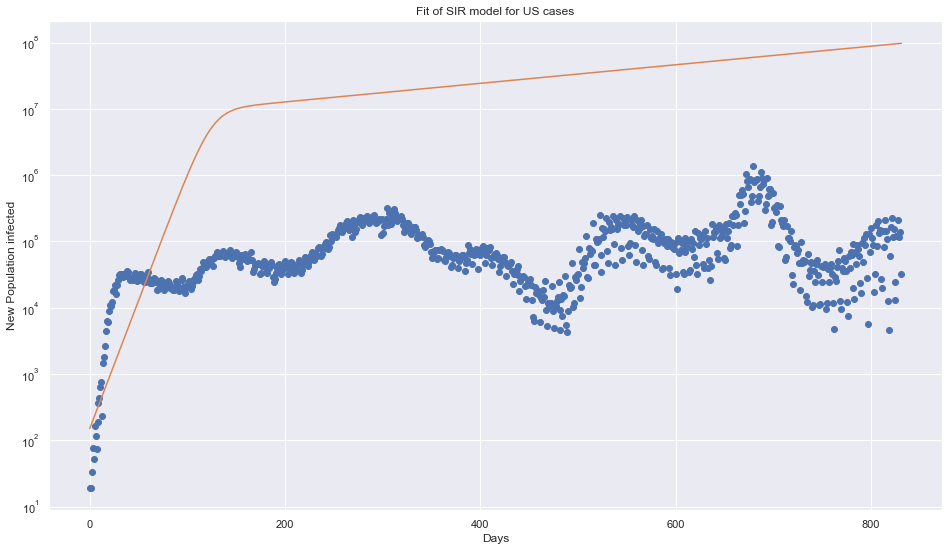

Optimal parameters: beta = 0.08582515669010742  and gamma =  -0.003227808452489312
Basic Reproduction Number R0  -26.5892967173806
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [26]:
plt.semilogy(t,np.ediff1d(ydata_u, to_begin=ydata_u[1]-ydata_u[0]), 'o')
plt.semilogy(t_u, us_fitted)

plt.title("Fit of SIR model for US cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt_u[0], " and gamma = ", popt_u[1])
print("Basic Reproduction Number R0 " , popt_u[0]/ popt_u[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

# Creating Dataframe for SIR dashboard

In [27]:
dash_dataframe = pd.DataFrame(t)
dash_dataframe.rename(columns={0:'date'}, inplace=True)

In [28]:
dash_dataframe['Germany_infected'], dash_dataframe['Germany_infected_fitted'] =pd.DataFrame(ydata), pd.DataFrame(germany_fitted)
dash_dataframe.head()

,date,Germany_infected,Germany_infected_fitted
0,0,150,150.000000
1,1,188,152.592776
2,2,240,155.230369
3,3,349,157.913553
4,4,534,160.643115


In [29]:
dash_dataframe['Italy_infected'], dash_dataframe['Italy_infected_fitted'] =pd.DataFrame(ydata_i), pd.DataFrame(italy_fitted)
dash_dataframe.head()

,date,Germany_infected,Germany_infected_fitted,Italy_infected,Italy_infected_fitted
0,0,150,150.000000,2036,150.000000
1,1,188,152.592776,2502,152.697714
2,2,240,155.230369,3089,155.443946
3,3,349,157.913553,3858,158.239567
4,4,534,160.643115,4636,161.085466


In [30]:
dash_dataframe['US_infected'], dash_dataframe['US_infected_fitted'] =pd.DataFrame(ydata_u), pd.DataFrame(us_fitted)
dash_dataframe.head()

,date,Germany_infected,Germany_infected_fitted,Italy_infected,Italy_infected_fitted,US_infected,US_infected_fitted
0,0,150,150.000000,2036,150.000000,55,150.000000
1,1,188,152.592776,2502,152.697714,74,163.970563
2,2,240,155.230369,3089,155.443946,107,179.242281
3,3,349,157.913553,3858,158.239567,184,195.936335
4,4,534,160.643115,4636,161.085466,237,214.185190


In [31]:
import plotly.graph_objects as go
import plotly
import dash
#import dash_core_components as dcc
#import dash_html_components as html
from dash import dcc
from dash import html

In [32]:
fig = go.Figure()

In [33]:
country_list = ['Italy',
               'US',
               'Germany'
               ]

# country drop-down list
option_list = []
for each in country_list:
    option = {'label':each, 'value':each+'_infected'}
    option_list.append(option)

In [34]:
app = dash.Dash()
app.layout = html.Div([
    html.Label('Multi-Select Country'),
    dcc.Dropdown(
        id='country_drop_down',
        options=option_list,
        #value=['US', 'Germany'],
        multi=False,
        value=option_list[0]['value'],
        placeholder='Filter by COUNTRY...'
    ),
    
    dcc.Graph(figure=fig, id='main_window_slope')
])

In [35]:
from dash.dependencies import Input, Output

@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value')]
)
def update_figure(country_drop_down):
    
    traces = []
    traces.append(dict(x = dash_dataframe.index,
                        y = dash_dataframe[country_drop_down],
                            mode = 'markers+lines',
                            line_width = 2,
                            marker_size = 1.5,
                            opacity = 0.9,
                            name = country_drop_down))
    traces.append(dict(x = dash_dataframe.index,
                        y = dash_dataframe[country_drop_down + str('_fitted')],
                            mode = 'lines',
                            line_width = 2,
                            marker_size = 1.5,
                            opacity = 0.9,
                            name = country_drop_down + str('_fitted')))
    return{
        'data': traces,
        'layout': dict (
            width =1000,
            height=800,
            xaxis_title = "Time",
            yaxis_title = "Confirmed infected Population (source johns hopkins case, log-scale)",
            xaxis = {'tickangle':-45,
                     'nticks':20,
                     'tickfont':dict(size=14, color="7f7f7f")
                    },
            yaxis = {'type':'log',
                    'range':'[1.1, 5.5]'
                    }
        )
    }

In [ ]:
app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
